Before continuing on, I would highly recommend reading [this article](https://lilianweng.github.io/lil-log/2018/01/23/the-multi-armed-bandit-problem-and-its-solutions.html#thompson-sampling) on multi-armed bandits.

## Setup

In [1]:
import numpy as np

Let's create two arms, the first with $\mu_1 = 0.25$ and second with $\mu_2 = 0.75$.

In [2]:
T = 500

In [3]:
arm_1 = np.random.binomial(size=T, n=1, p=0.25)
arm_2 = np.random.binomial(size=T, n=1, p=0.75)
ARMS  = [arm_1, arm_2]

Check that the arms were correctly implemented.

In [4]:
np.mean(arm_1), np.mean(arm_2)

(0.26200000000000001, 0.75)

In [5]:
def algorithm_dict(results):
    return {'total': results[0], 'samples': results[1], 'weights': results[2], 'opt': results[3]}

Ok, let's begin!

## Multiplicative Weights

**Main Idea**: reduce bandits to sequence prediction by ignoring some of the data with probability $p$.

In [6]:
def MW(arms, T, p):
    """
    Implementation of Multiplicative-Weights.
    
    p (float): probability of exploring a random arm.
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)]
    
    ETA         = np.sqrt(np.log(NUM_ARMS) / ((1 - p) * T))
    TOTAL_REWARD= [0]
    ACCUM_REWARD= [[0] for _ in range(NUM_ARMS)]
    
    for t in range(T):
        
        COINFLIP= np.random.uniform()
                
        # EXPLOIT
        if COINFLIP > NUM_ARMS * p:
            
            # Get scaled accumulated reward for each arm.
            REWARD_HAT   = [ACCUM_REWARD[i][-1] / (1 - p) for i in range(NUM_ARMS)]
            
            # Get weight of each arm.
            WEIGHTS      = np.exp(list(map(lambda arm: arm * ETA, REWARD_HAT)))
            
            # Get reward of each arm for current round.
            ROUND_REWARD = list(map(lambda arm: arm[t], arms))
            
            # Add averaged reward to total rewards.
            TOTAL_REWARD.append(TOTAL_REWARD[t] + sum(map(lambda p, r: p * r,
                WEIGHTS / sum(WEIGHTS), ROUND_REWARD)))
                    
        # EXPLORE
        else:
            
            # Pull a random arm with uniform probability.
            RAND_ARM = np.random.randint(NUM_ARMS)
            # Add the reward to that arms accumulated rewards.
            ACCUM_REWARD[RAND_ARM].append(ACCUM_REWARD[RAND_ARM][-1] + arms[RAND_ARM][t])
            # Add the reward to total reward.
            TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[RAND_ARM][t])
    
    return TOTAL_REWARD, ACCUM_REWARD, WEIGHTS / sum(WEIGHTS), np.argmax(WEIGHTS)
    

## Epsilon Greedy

**Main Idea:** randomly explore an arm with probability $e$, and otherwise exploit the best arm found so far.

In [7]:
def EG(arms, T, e):
    """
    episilon-Greedy.
    
    e (float): probability of exploring a random arm.
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)]
    
    TOTAL_REWARD= [0]
    
    for t in range(T):
        
        COINFLIP= np.random.uniform()
        
        # EXPLOIT
        if COINFLIP > e:
            
            ARM_MEAN_HAT= list(map(np.mean, ARM_SAMPLES))
            BEST_ARM    = np.argmax(ARM_MEAN_HAT)   
            
            # Add the reward to that arms accumulated rewards.
            ARM_SAMPLES[BEST_ARM].append(arms[BEST_ARM][t])
            # Add the reward to total reward.
            TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[BEST_ARM][t])          
                    
        # EXPLORE
        else:
            
            # Pull a random arm with uniform probability.
            RAND_ARM = np.random.randint(NUM_ARMS)
            # Add the reward to that arms accumulated rewards.
            ARM_SAMPLES[RAND_ARM].append(arms[RAND_ARM][t])
            # Add the reward to total reward.
            TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[RAND_ARM][t])
    
    
    ARM_MEAN_HAT= list(map(np.mean, ARM_SAMPLES))
    BEST_ARM    = np.argmax(ARM_MEAN_HAT)   
    
    return TOTAL_REWARD, ARM_SAMPLES, ARM_MEAN_HAT, BEST_ARM
    

## stupid Upper Confidence Bound

**Main Idea**: explore each arm for a fixed number of rounds, and otherwise exploit the best arm found so far.

In [8]:
def sUCB(arms, T, T_naut):
    """
    'stupid' Upper Confidence Bound.
    
    T_naut (int): number of rounds to dedicate towards exploring each arm.
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)]
    
    TOTAL_REWARD= [0]
    
    for t in range(0, NUM_ARMS * T_naut):
        
        SAMPLE  = arms[t % NUM_ARMS][t]
        
        ARM_SAMPLES[t % NUM_ARMS].append(SAMPLE)
        TOTAL_REWARD.append(TOTAL_REWARD[t] + SAMPLE)
        

    ARM_MEAN_HAT= list(map(np.mean, ARM_SAMPLES))
    BEST_ARM    = np.argmax(ARM_MEAN_HAT)
    
    for t in range(NUM_ARMS * T_naut, T):
        SAMPLE  = arms[BEST_ARM][t]   
        TOTAL_REWARD.append(TOTAL_REWARD[t] + SAMPLE)

    return TOTAL_REWARD, ARM_SAMPLES, ARM_MEAN_HAT, BEST_ARM

## Upper Confidence Bound

**Main Idea**: combine exploration and exploitation by pulling the best arm found so far while also considering how confident we are about that arm being the best.

In [9]:
def UCB(arms, T, alpha):
    """
    Upper Confidence Bound with general Hoeffding.
    
    alpha (float): hyperparameter to decrease bound as function of T.
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)]
    TOTAL_REWARD= [0]
    
    # Initial Exploration so ARM_SAMPLES isn't NaN.
    for t in range(0, NUM_ARMS):
        
        ARM_SAMPLES[t].append(arms[t][t])
        TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[t][t])
    
    # UCB algorithm for remaining rounds.
    for t in range(NUM_ARMS, T):
        
        ARM_MEAN= list(map(np.mean, ARM_SAMPLES))
        UP_BOUND= list(map(lambda arm: np.sqrt(alpha * np.log(t) / (2 * len(arm))), ARM_SAMPLES))
        
        UC_BOUND= list(map(sum, zip(ARM_MEAN, UP_BOUND)))
        
        BEST_ARM= np.argmax(UC_BOUND)
        
        ARM_SAMPLES[BEST_ARM].append(arms[BEST_ARM][t])
        TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[BEST_ARM][t])
    
    return TOTAL_REWARD, ARM_SAMPLES, UC_BOUND, BEST_ARM

## Bayesian UCB

**Main Idea**: we can have a better bound by using fact each arm is Bernoulli.

In [10]:
def bUCB(arms, T, init_a=1, init_b=1, c=3):
    """
    Bayes Upper Confidence Bound.
    
    c (float): how many standard dev to consider as UCB.
    init_a (int array): initial values of a in Beta(a, b).
    init_b (int array): initial values of b in Beta(a, b).    
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)]
    
    for ARM in ARM_SAMPLES:
        ARM += [1] * init_a + [0] * init_b
        
    TOTAL_REWARD= [0]
    
    def calculate_beta_std(arm):
        alpha, beta = sum(arm), len(arm) - sum(arm)
        return np.sqrt(alpha * beta / ((alpha + beta)**2 * (alpha + beta + 1)))
    
    # Initial Exploration so ARM_SAMPLES isn't NaN.
    for t in range(0, NUM_ARMS):
        
        ARM_SAMPLES[t].append(arms[t][t])
        TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[t][t])
    
    # UCB algorithm for remaining rounds.
    for t in range(NUM_ARMS, T):
        
        ARM_MEAN= list(map(np.mean, ARM_SAMPLES))
        UP_BOUND= list(map(lambda arm: c * calculate_beta_std(arm), ARM_SAMPLES))
        
        UC_BOUND= list(map(sum, zip(ARM_MEAN, UP_BOUND)))
        
        BEST_ARM= np.argmax(UC_BOUND)
        
        ARM_SAMPLES[BEST_ARM].append(arms[BEST_ARM][t])
        TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[BEST_ARM][t])
    
    return TOTAL_REWARD, ARM_SAMPLES, UC_BOUND, BEST_ARM

## Thompson Sampling

**Main Idea**: we can do better than bayesian UCB by sampling the posterior distribution of each arm's mean. In this case, we assume the prior and posterior distributions are in the same distribution family, so we can use [conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior).

In [11]:
def TS(arms, T, init_a=1, init_b=1):
    """
    Thompson Sampling.
    
    init_a (int array): initial values of a in Beta(a, b).
    init_b (int array): initial values of b in Beta(a, b).
    """
    NUM_ARMS    = len(arms)
    ARM_SAMPLES = [[] for _ in range(NUM_ARMS)] 
    
    for ARM in ARM_SAMPLES:
        ARM += [1] * init_a + [0] * init_b
        
    TOTAL_REWARD= [0]
    
    for t in range(T):
        
        # Sample the posterior for mean.
        MEAN_HAT = [np.random.beta(sum(ARM), len(ARM) - sum(ARM)) for ARM in ARM_SAMPLES]
        
        # Select arm with best estimated mean.
        BEST_ARM =  np.argmax(MEAN_HAT)
        
        ARM_SAMPLES[BEST_ARM].append(arms[BEST_ARM][t])
        TOTAL_REWARD.append(TOTAL_REWARD[t] + arms[BEST_ARM][t])

    return TOTAL_REWARD, ARM_SAMPLES, MEAN_HAT, BEST_ARM

# Plots

In [12]:
import matplotlib.pyplot as plt
import operator

In [13]:
arm_1_sum = np.cumsum(arm_1)
arm_2_sum = np.cumsum(arm_2)

In [35]:
MW_results  = algorithm_dict(MW(ARMS,  T, p=0.2))
EG_results  = algorithm_dict(EG(ARMS,  T, e=0.2))
sUCB_results= algorithm_dict(sUCB(ARMS,T, T_naut=30))
UCB_results = algorithm_dict(UCB(ARMS, T, alpha=2))
bUCB_results= algorithm_dict(bUCB(ARMS,T))
TS_results  = algorithm_dict(TS(ARMS,  T))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
def calculate_regret(best_arm, algorithm_rewards):
    return list(map(operator.sub, best_arm, algorithm_rewards))

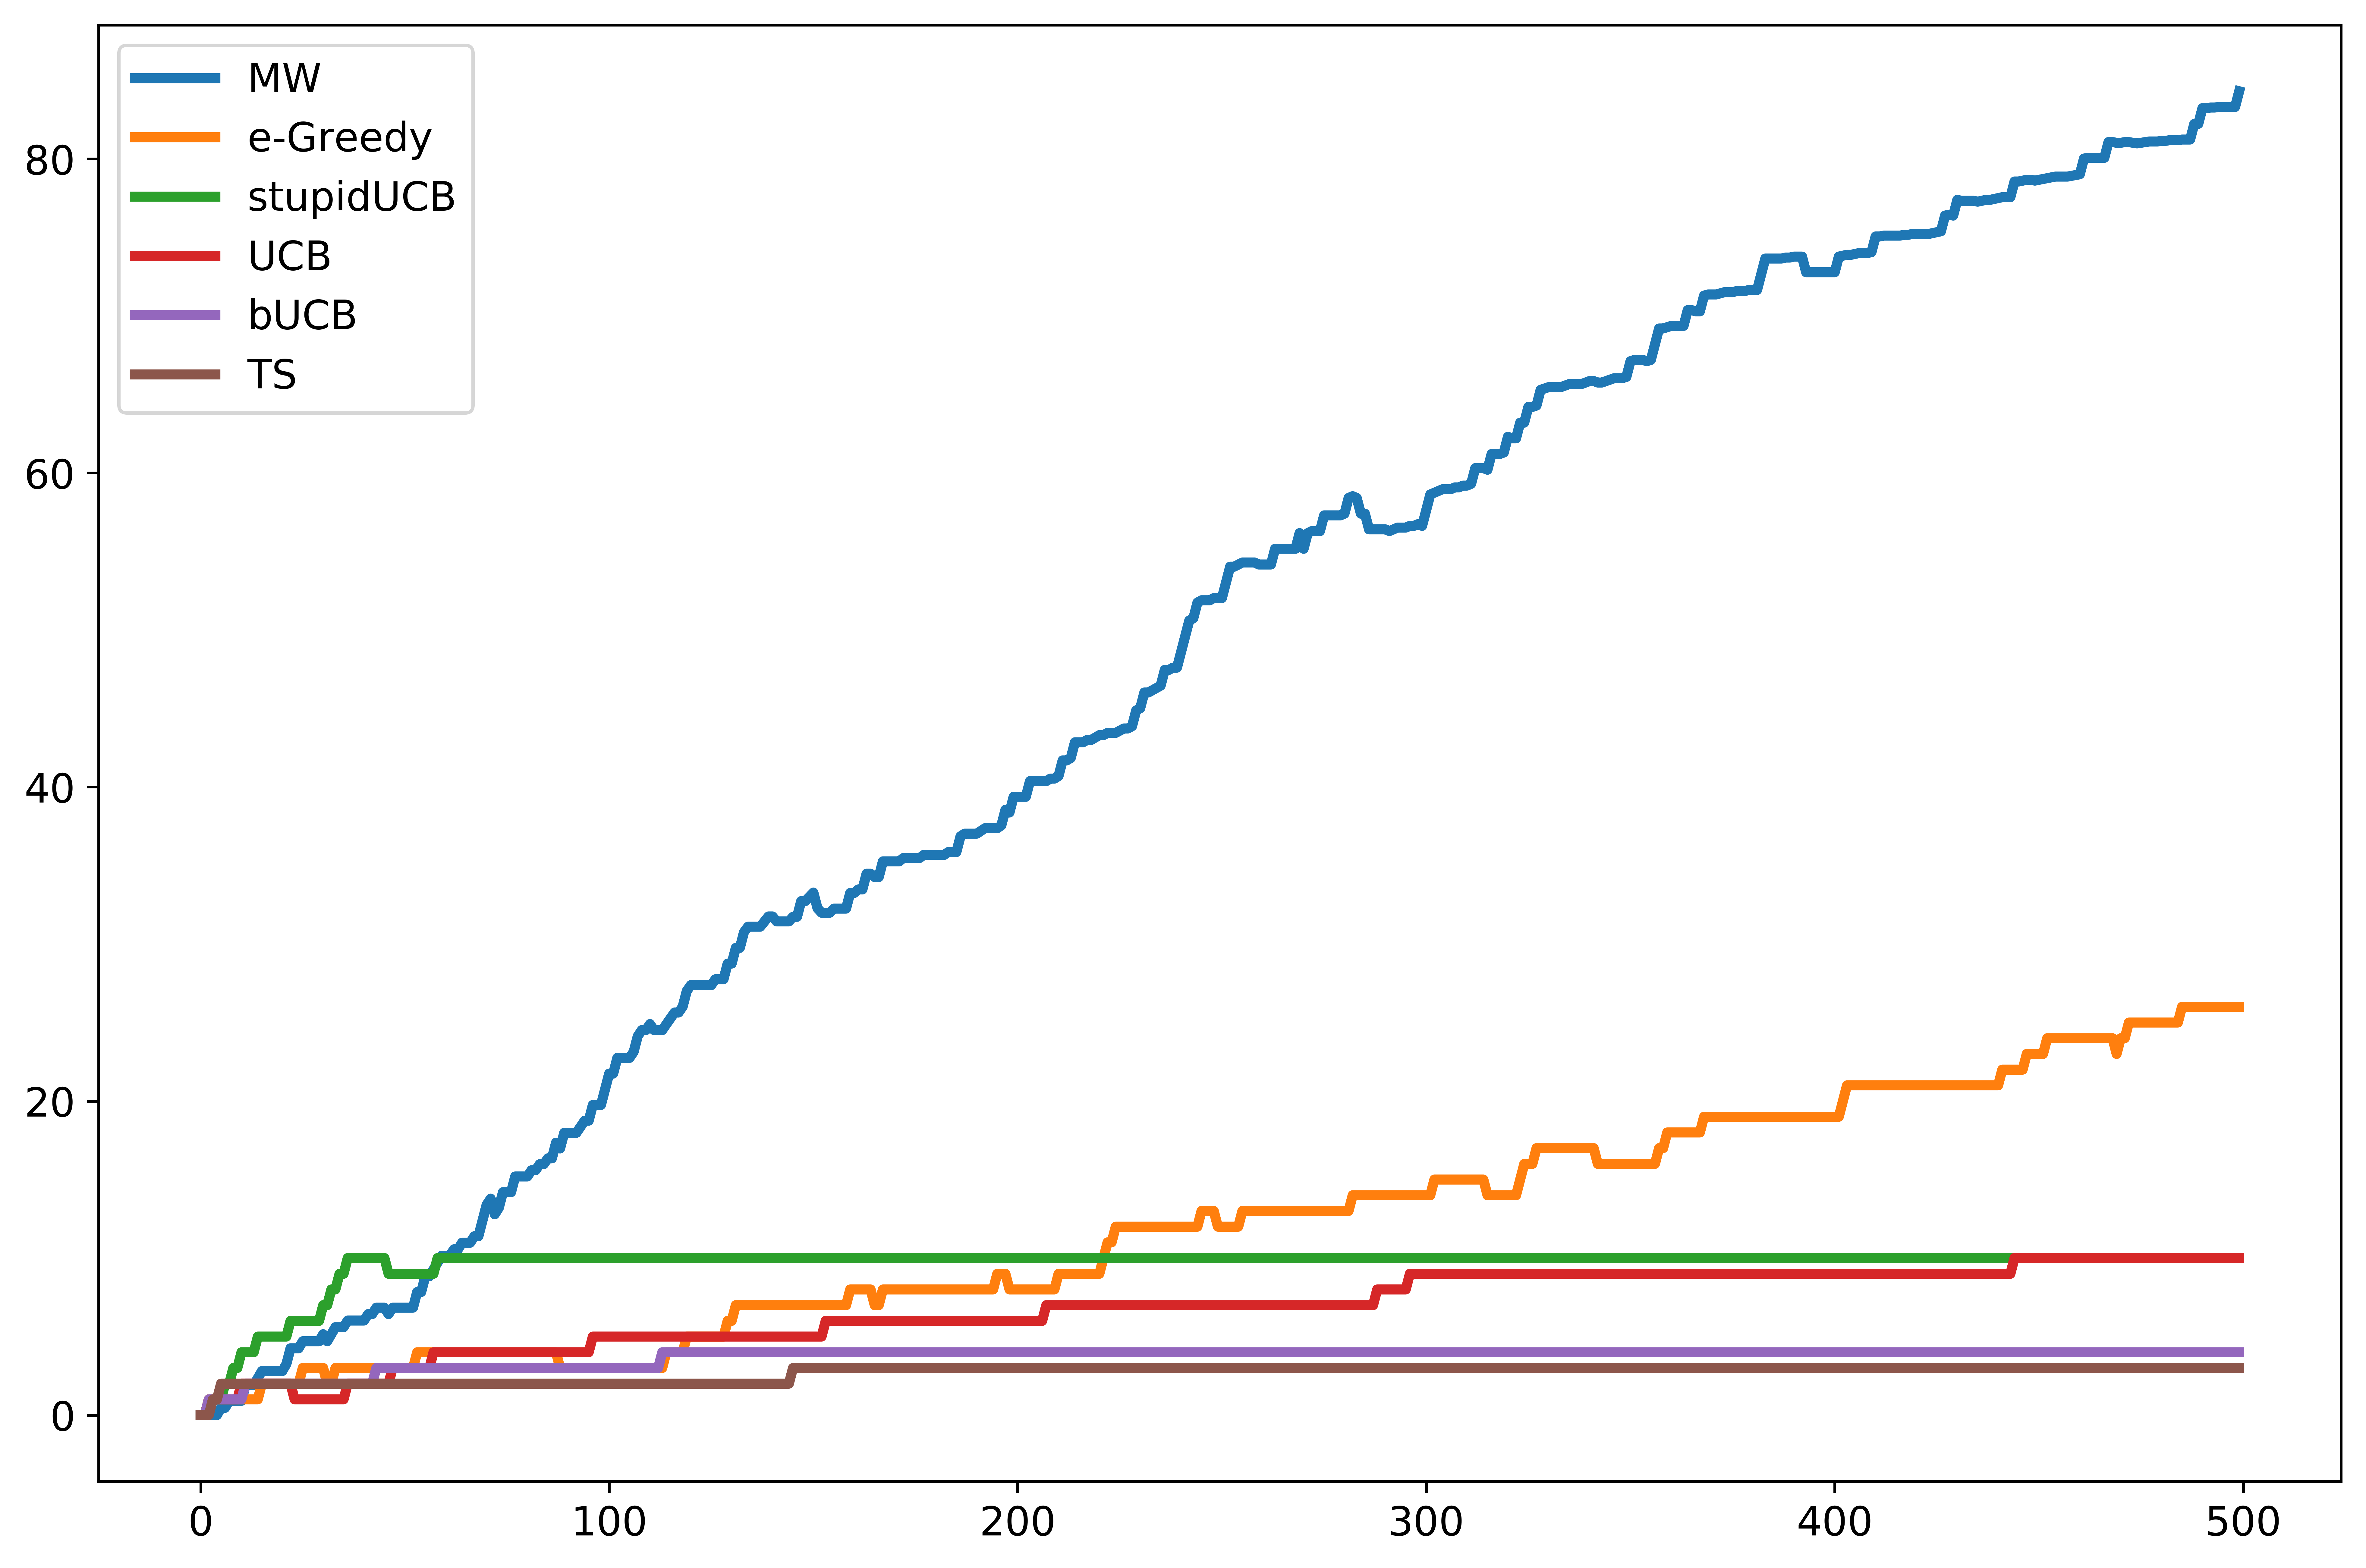

In [37]:
plt.rc('font', size=12) 
plt.figure(figsize=(12, 8), dpi=800)
plt.plot(range(T), calculate_regret(arm_2_sum,   MW_results['total'][1:]), label="MW",       linewidth=3)
plt.plot(range(T), calculate_regret(arm_2_sum,   EG_results['total'][1:]), label="e-Greedy", linewidth=3)
plt.plot(range(T), calculate_regret(arm_2_sum, sUCB_results['total'][1:]), label="stupidUCB",linewidth=3)
plt.plot(range(T), calculate_regret(arm_2_sum,  UCB_results['total'][1:]), label="UCB",      linewidth=3)
plt.plot(range(T), calculate_regret(arm_2_sum, bUCB_results['total'][1:]), label="Bayes UCB",linewidth=3)
plt.plot(range(T), calculate_regret(arm_2_sum,   TS_results['total'][1:]), label="TS",       linewidth=3)
plt.legend(loc=2)
plt.show()

## More Arms!

In [27]:
MU       = [0.25, 0.35, 0.50, 0.65, 0.75]
ARMS     = [np.random.binomial(size=T, n=1, p=mu) for mu in MU]
BEST_ARM =  np.cumsum(max(ARMS, key=lambda arm: sum(arm)))

In [28]:
T = 1000

In [29]:
MW_results  = algorithm_dict(MW(ARMS,  T, p=1-(1/T)**(1/3)))
EG_results  = algorithm_dict(EG(ARMS,  T, e=0.1))
sUCB_results= algorithm_dict(sUCB(ARMS,T, T_naut=100))
UCB_results = algorithm_dict(UCB(ARMS, T, alpha=2))
bUCB_results= algorithm_dict(bUCB(ARMS,T))
TS_results  = algorithm_dict(TS(ARMS,  T))

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


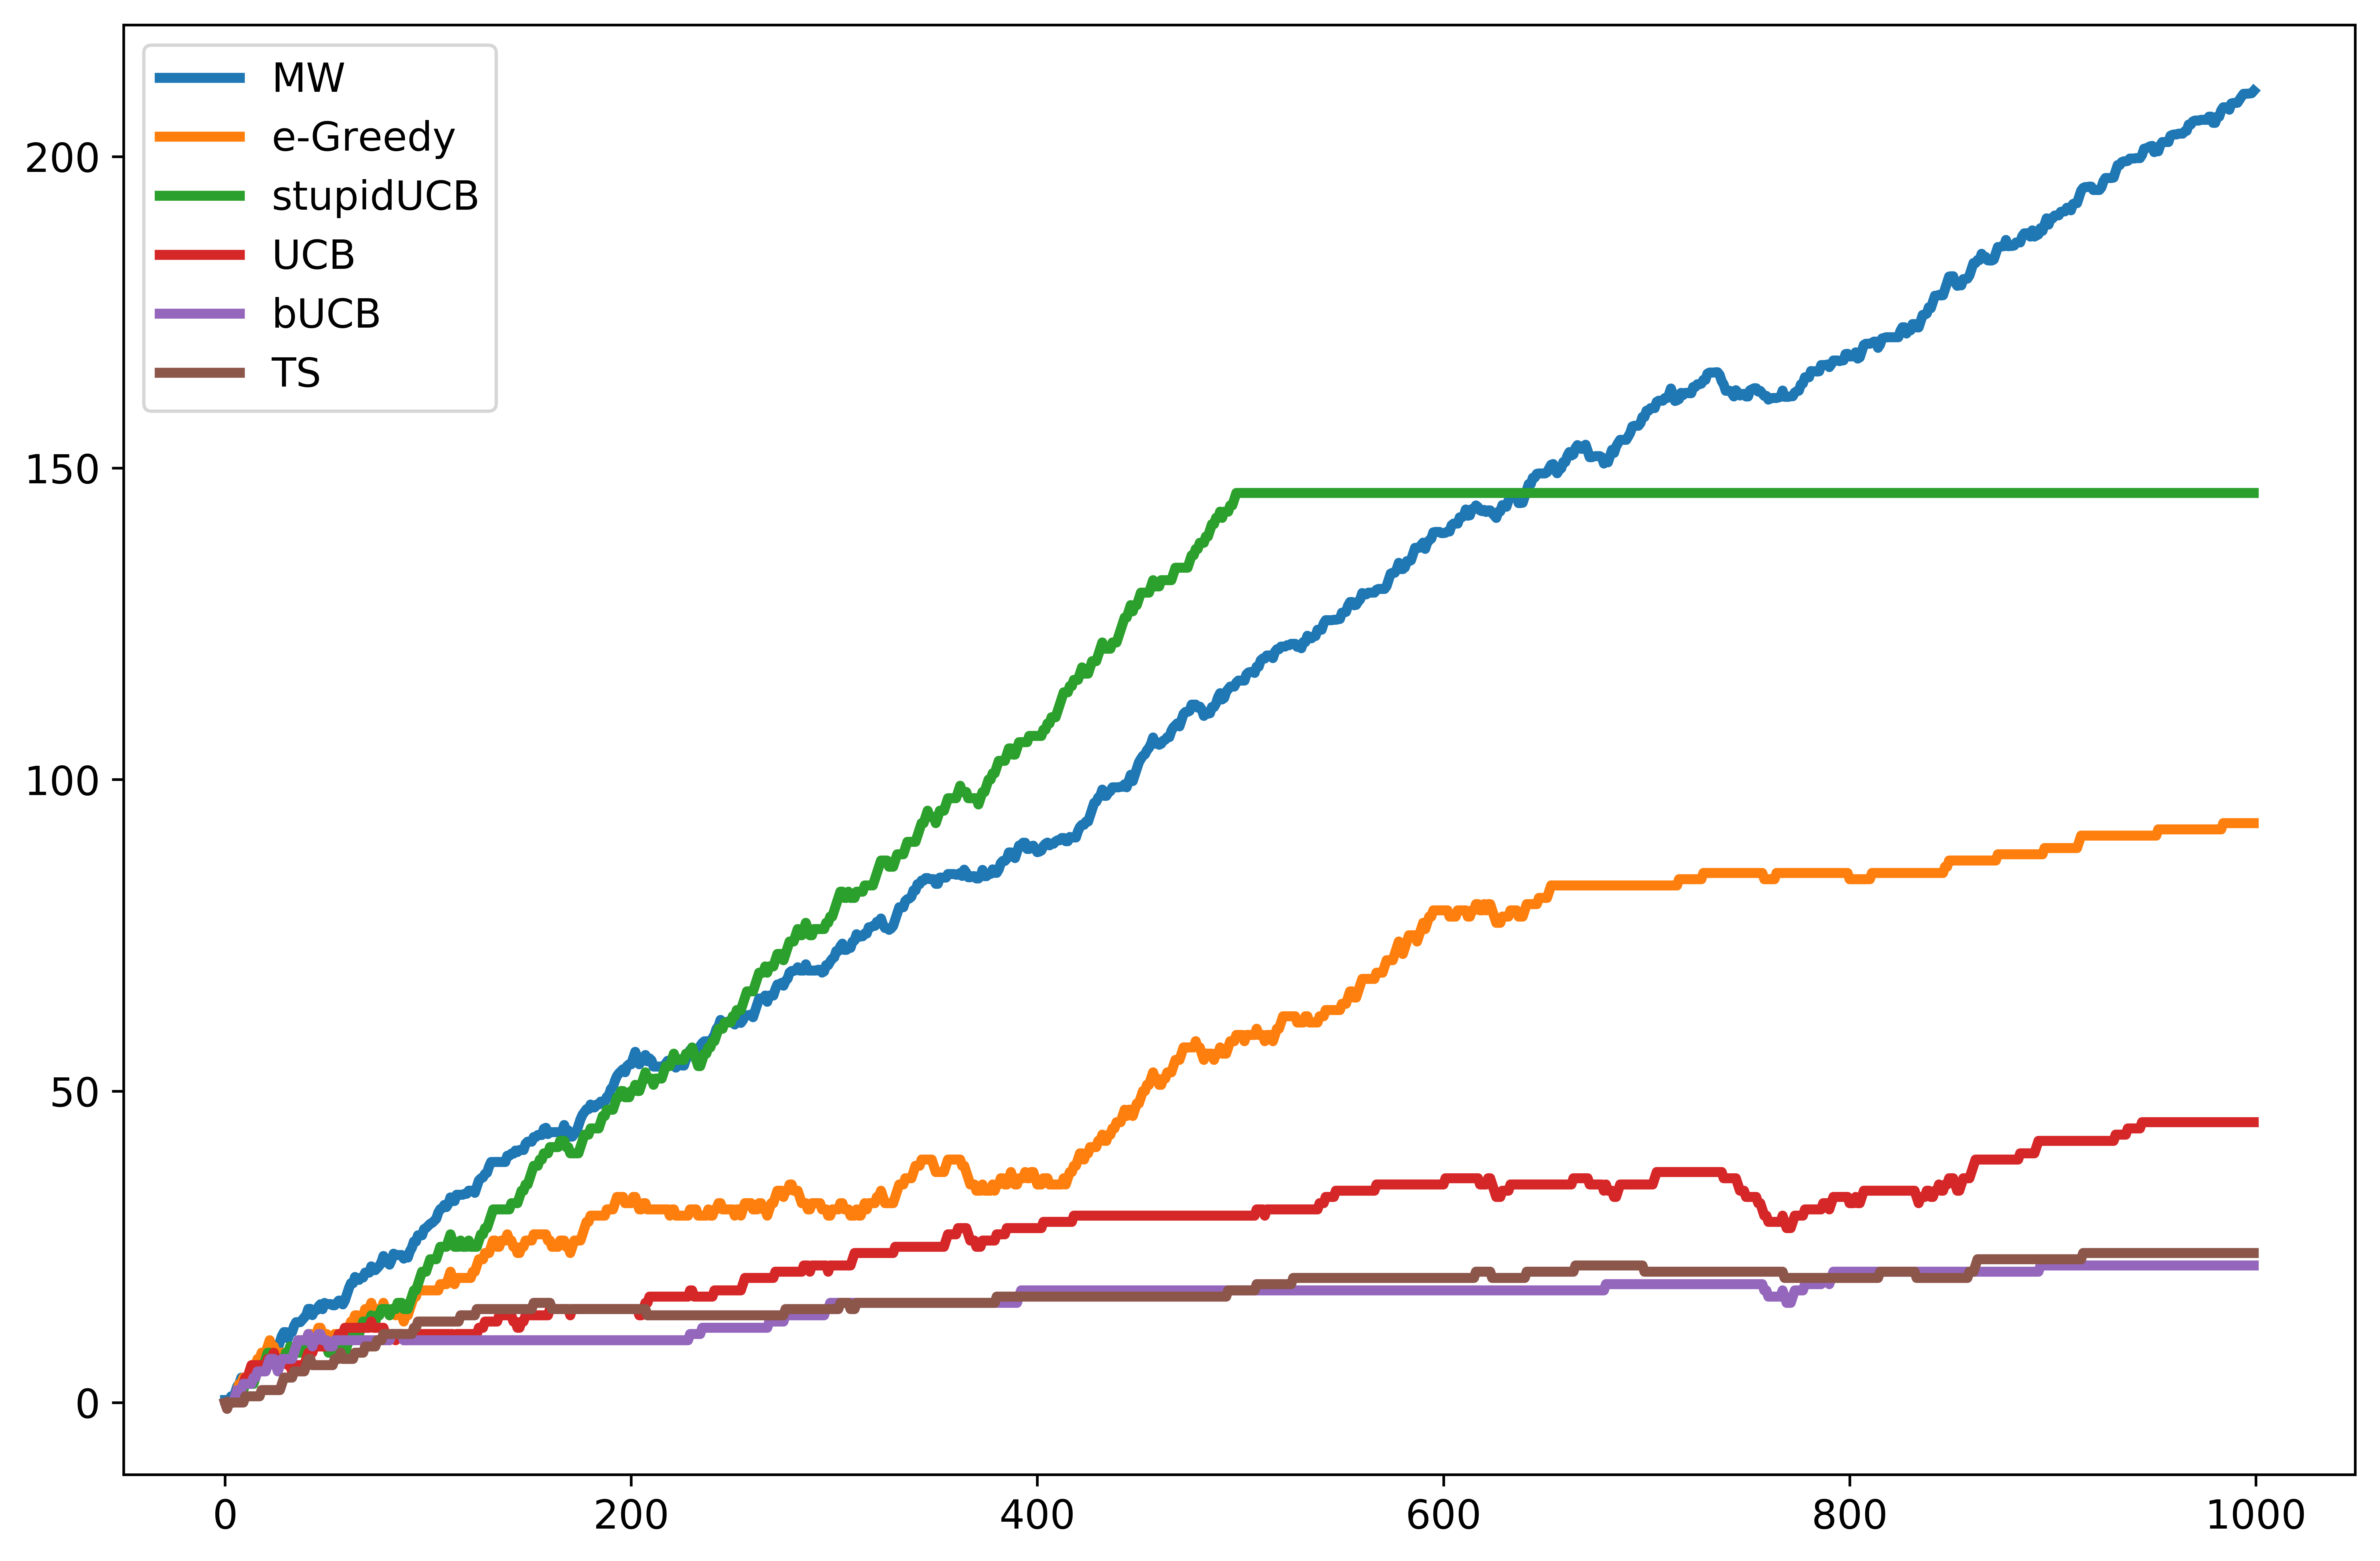

In [30]:
plt.rc('font', size=12) 
plt.figure(figsize=(12, 8), dpi=800)
plt.plot(range(T), calculate_regret(BEST_ARM,   MW_results['total'][1:]), label="MW",       linewidth=3)
plt.plot(range(T), calculate_regret(BEST_ARM,   EG_results['total'][1:]), label="e-Greedy", linewidth=3)
plt.plot(range(T), calculate_regret(BEST_ARM, sUCB_results['total'][1:]), label="stupidUCB",linewidth=3)
plt.plot(range(T), calculate_regret(BEST_ARM,  UCB_results['total'][1:]), label="UCB",      linewidth=3)
plt.plot(range(T), calculate_regret(BEST_ARM, bUCB_results['total'][1:]), label="Bayes UCB",linewidth=3)
plt.plot(range(T), calculate_regret(BEST_ARM,   TS_results['total'][1:]), label="TS",       linewidth=3)
plt.legend(loc=2)
plt.show()

In [31]:
MW_results['opt'], EG_results['opt'], sUCB_results['opt'], UCB_results['opt'], bUCB_results['opt'], TS_results['opt']

(4, 4, 4, 4, 4, 4)

In [38]:
max(range(len(ARMS)), key=lambda i: sum(ARMS[i]))

4